# Figure 1: generalisability & normative enrichments

## Setup

In [2]:
# Set working directory
%cd work/notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks


In [490]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *

### Compute components

First process AHBA data into a gene-by-region matrix and save to `/outputs`.

 `get_expression_abagen` is a wrapper around `abagen.get_expression_data` from the _abagen_ package that processes the AHBA with additional gene and region filters.
See: `code/processing.py`

In [ ]:
# get_expression_abagen(fetch_hcp(), donors_threshold=0, gene_stability_threshold=0, save_name='hcp_base')
# get_expression_abagen(fetch_hcp(), donors_threshold=3, gene_stability_threshold=0.5, save_name='hcp_3d_ds5')

Then find components: a base version using all data and PCA, and an optimised version using filtered data with DME.

`gradientVersion` is a wrapper around the `GradientMaps` class from the _BrainSpace_ package. See `code/gradientVersion.py`

In [13]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [14]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

Output scores and weights

In [494]:
dme_3d_ds5.clean_scores().to_csv('../outputs/ahba_dme_hcp_top8kgenes_scores.csv')
dme_3d_ds5.weights.iloc[:,:3].to_csv('../outputs/ahba_dme_hcp_top8kgenes_weights.csv')

---

## Generalisability and brain maps of components

In [15]:
versions_scores = pd.concat({
   'PCA, all genes\nall regions': pca_base.clean_scores(),
   'DME, top 50% genes\nonly 3+ donor regions': dme_3d_ds5.clean_scores(),
}).reset_index(level=0).rename({'level_0': 'version'}, axis=1)

Triplets analysis requires re-processing AHBA for every permutation of data splits of the six brains. Uses functions in `code/triplets.py`. Run once and save to `/outputs`:

In [ ]:
# triplets_base = get_triplets(atlas=fetch_hcp(), donors_threshold=0)
# save_pickle(triplets_base, "triplets_base")

# triplets_3donors = get_triplets(atlas=fetch_hcp(), donors_threshold=3)
# save_pickle(triplets_3donors, "triplets_3donors")

For each triplets split, compute generalisability _g_ (i.e. absolute correlation of region scores) across different gene filter levels and save to `/outputs`.

In [16]:
# triplets_base = load_pickle('triplets')
# triplets_3donors = load_pickle('triplets_3donors')

# triplets_dict = {
#     'PCA, all regions': make_triplet_ds_plot(get_triplets_stability_levels(triplets_base)),
#     'DME, only 3+ donor regions': make_triplet_ds_plot(get_triplets_stability_levels(triplets_3donors))
# }
# save_pickle(triplets_dict, 'triplets_dict')

triplets_dict = load_pickle('triplets_dict')

Now we can present the results and plot panels **a** and **b**:

In [17]:
triplets_df = pd.concat({
    "PCA, all genes\nall regions": triplets_dict['PCA, all regions'].loc[lambda x: x['version']==0],
    "DME, top 50% genes\nonly 3+ donor regions": triplets_dict['DME, only 3+ donor regions'].loc[lambda x: x['version']==0.5]
}).drop('version', axis=1).reset_index(0).rename({'level_0':'version'}, axis=1)
# triplets_df

In [18]:
triplets_df.groupby(['version','how','component']).median()

corr  \
version                                   how           component             
DME, top 50% genes\nonly 3+ donor regions Region scores 1          0.956908   
                                                        2          0.666887   
                                                        3          0.643539   
                                                        4         -0.140626   
                                                        5         -0.010216   
PCA, all genes\nall regions               Region scores 1         -0.191852   
                                                        2          0.068152   
                                                        3          0.032535   
                                                        4         -0.112639   
                                                        5          0.033329   

                                                                   corr_abs  
version                                   how           component            
DME, top 50% genes\nonly 3+ donor regions Region scores 1          0.956908  
                                                        2          0.723390  
                                                        3          0.643539  
                                                        4          0.279726  
                                                        5          0.330640  
PCA, all genes\nall regions               Region scores 1          0.721299  
                                                        2          0.118019  
                                                        3          0.112725  
                                                        4          0.145198  
                                                        5          0.298827

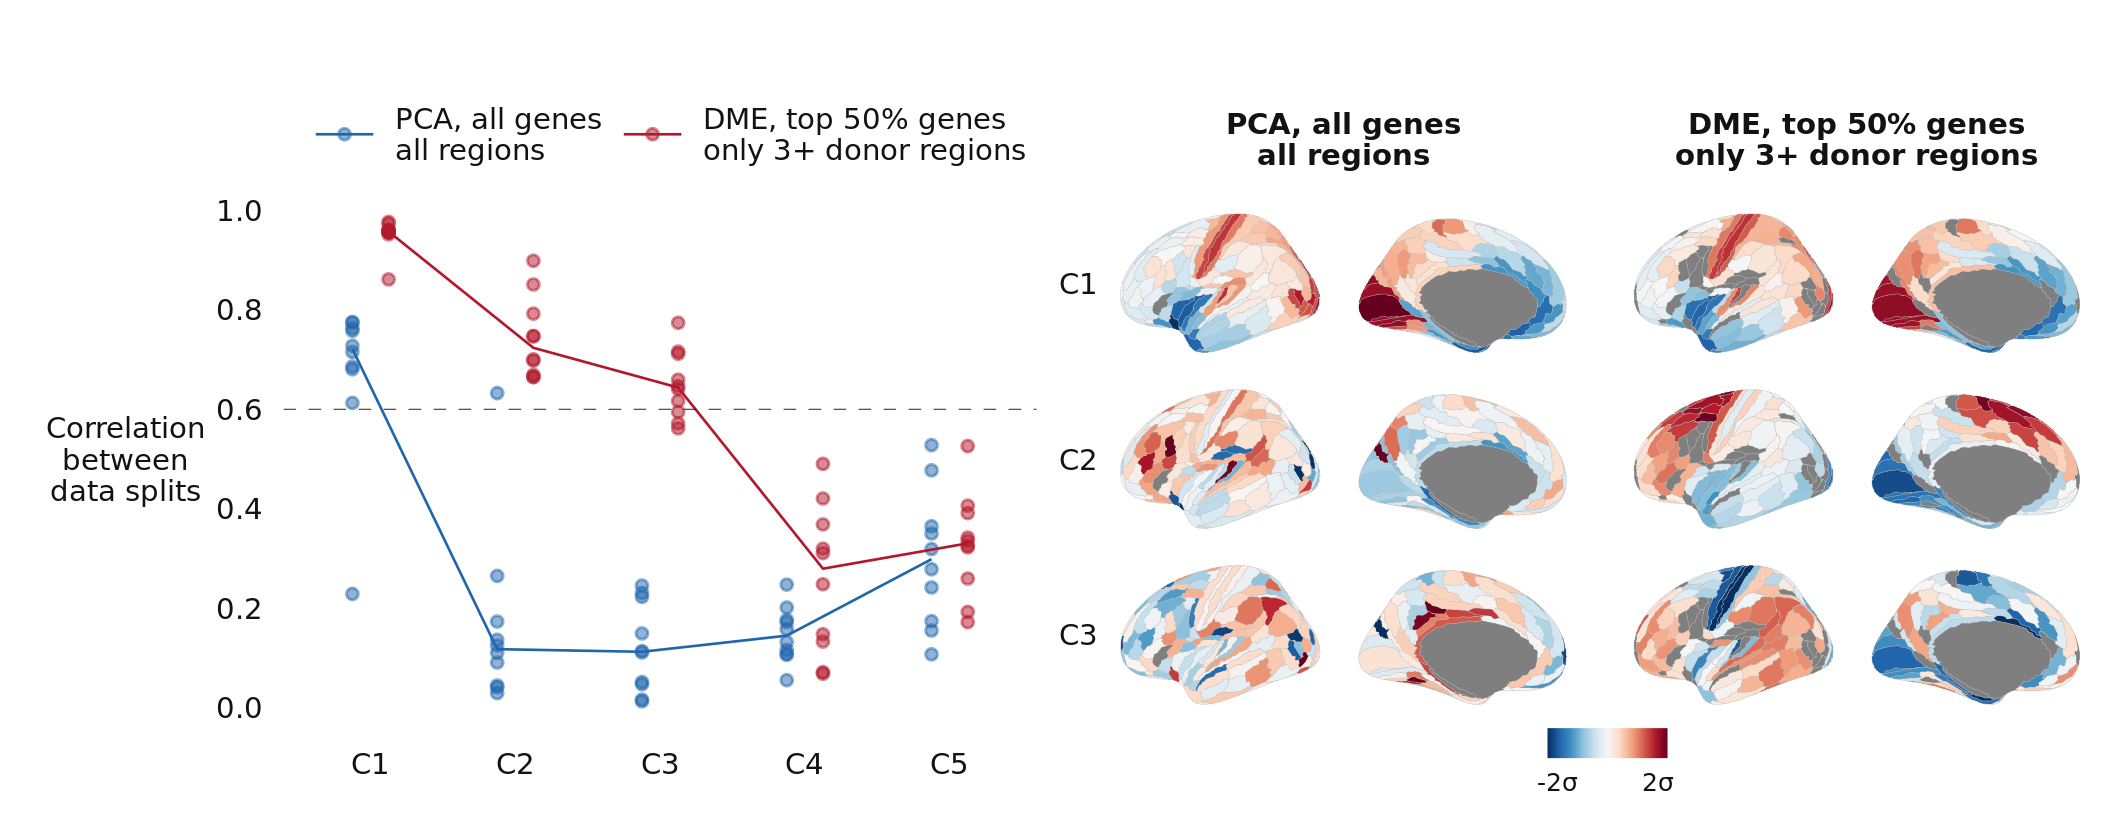

In [179]:
%%R -i triplets_df -i versions_scores -w 180 -h 70 --units mm -r 300
source("../code/fig1_plots.R")

c1 <- plot_generalisability(triplets_df) + 
        # scale_color_manual(values=c(brewer.rdbu(10)[c(9)], 'white')) +
        ylab('Correlation\nbetween\ndata splits')
c2 <- plot_brain_maps(versions_scores)

(c1 + c2 + plot_layout(widths=c(1.5,2)) )

---

## Normative enrichments

Use code from `code/enrichments_data.py` and `code/enrichments.py` to compute normative enrichments for: **c** Gene Ontology (GO) Biological Processes, **d** cortical layers, **e** cell types, **f** educational attainment GWAS, and **g** intelligence GWAS.

### GO enrichments

GO BP_enrichments are computed externally in _STRING_ online software. (Results when computed directly are similar)

In [21]:
go_enrichments = combine_go_enrichments('dm_hcp_3d_ds5', 'Process', include_c1=True, top_n=1000, FDR_filter=0.05)

In [22]:
pd.options.display.max_rows=20
go_enrichments.loc[lambda x: x['C']=='C3'].loc[lambda x: x['direction']=='top'].sort_values(['direction', 'FDR']).reset_index(drop=True)
# go_enrichments.loc[lambda x: x['C']=='C3'].loc[lambda x: x['direction']=='bottom'].sort_values(['direction', 'FDR']).reset_index(drop=True)


,C,direction,description,n_genes,enrichment,FDR,neglogFDR,FDR_rank,enrichment_rank,rank,maxrank
0,C3,top,Inflammatory response,185,1.197250,0.000006,5.222573,1.0,67.0,84.0,84.0
1,C3,top,Extracellular matrix organization,163,1.571650,0.000016,4.804100,2.0,48.0,83.0,84.0
2,C3,top,Antigen processing,8,7.455150,0.000039,4.404504,3.0,1.0,82.0,84.0
3,C3,top,Blood vessel morphogenesis,192,1.542370,0.000053,4.274905,4.0,50.0,81.0,84.0
4,C3,top,Regulation of angiogenesis,141,1.402990,0.000210,3.677781,5.0,58.0,80.0,84.0
5,C3,top,Regulation of vasculature development,158,1.297320,0.000510,3.292430,6.0,63.0,79.0,84.0
6,C3,top,Positive regulation of cell adhesion,176,1.256890,0.001300,2.886057,7.0,65.0,78.0,84.0
7,C3,top,Artery morphogenesis,27,2.935680,0.003000,2.522879,8.0,30.0,77.0,84.0
8,C3,top,Detection of external biotic stimulus,10,4.880310,0.003400,2.468521,9.0,16.0,76.0,84.0
9,C3,top,T cell activation,90,1.451660,0.004400,2.356547,10.0,54.0,75.0,84.0


In [497]:
go_enrichments.to_csv("../outputs/ahba_GO_enrichments.csv")

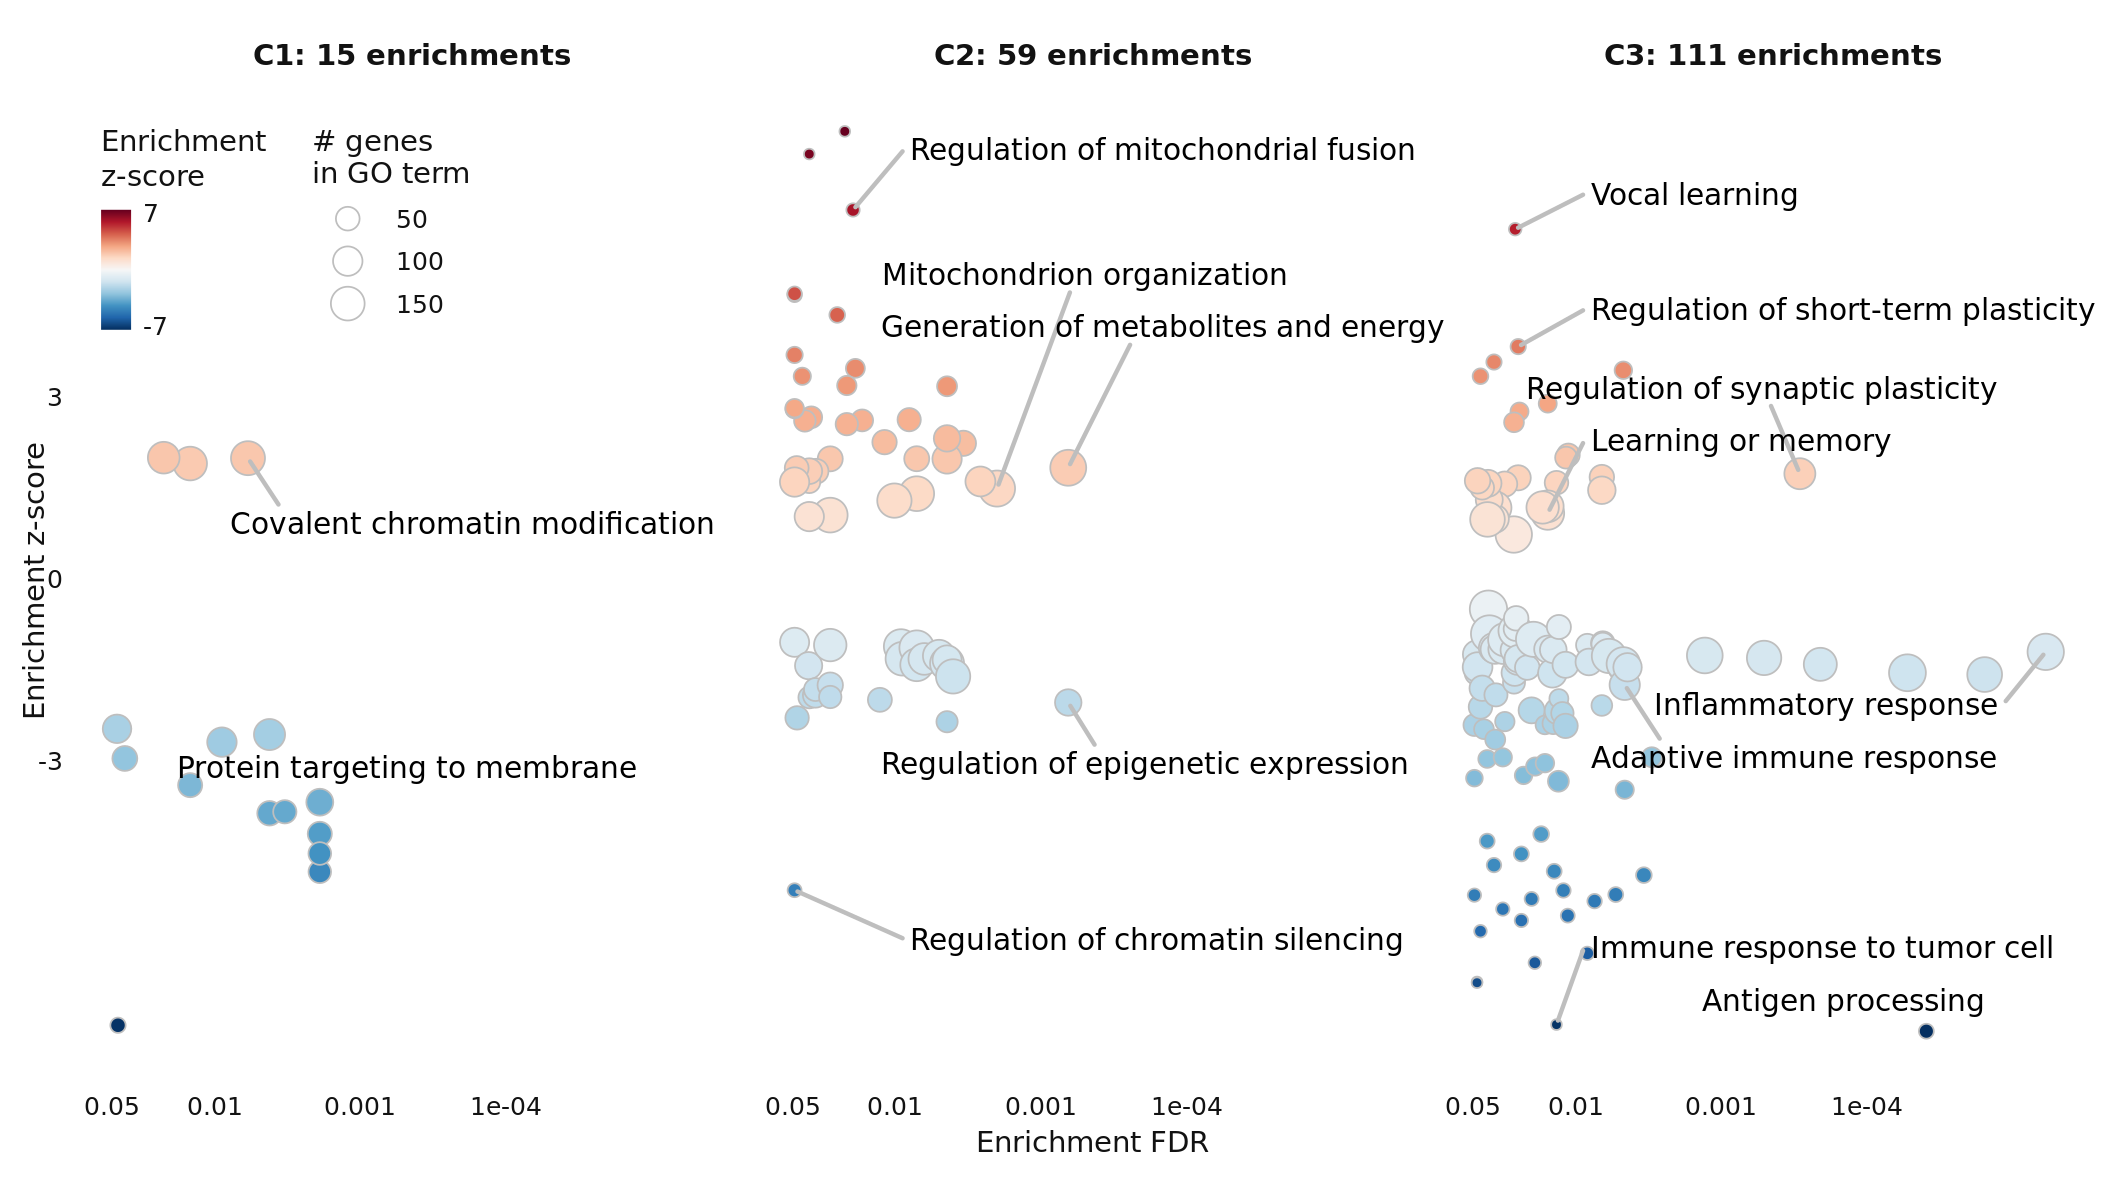

In [23]:
%%R -i go_enrichments -w 180 -h 100 -u mm -r 300
source("../code/fig1_plots.R")
plot_go_enrichments(go_enrichments)

### Layer enrichments

In [24]:
layer_genes = get_layer_genes(which='maynard', add_hse_genes=False)
layer_stats = compute_null_p(*compute_enrichments(weights, null_weights, layer_genes))

### Cell enrichments

In [25]:
cell_genes = get_cell_genes(which='jakob', add_synapses=True)
order = ['Synapses', 'Neuro-Ex', 'Neuro-In', 'Astro', 'Micro', 'Endo', 'Oligo', 'OPC']
true_scores, null_scores, counts = compute_enrichments(weights, null_weights, cell_genes, how='mean')
cell_stats = compute_null_p(true_scores, null_scores, adjust='fdr_bh', order=order)

In [26]:
cell_rename = {
    'Synapses':'Syn',
    'Neuro-Ex':'N-Ex',
    'Neuro-In':'N-In',
    'Astro':'Astro',
    'Micro':'Micro',
    'Endo':'Endo',
    'Oligo':'Oligo',
    'OPC':'OPC'
}
# cell_rename = {v:k for k,v in cell_rename.items()}
    
cell_stats = cell_stats.replace({'label':cell_rename}).sort_values(['label','C'])


### GWAS enrichments

In [27]:
gwas_intelligence = get_intelligence_gwas_genes()
order = ['Davies 2018','Savage 2018','Hill 2019','Hatoum 2022']
gwas_intelligence_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_intelligence), order=order)
gwas_intelligence_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
3,Davies 2018,C1,0.9466,0.020229,-0.032620,0.033724,1.567102,True,0.1068,0.128160,False,709,289
4,Davies 2018,C2,0.0072,-0.018014,0.026724,0.018360,-2.436665,False,0.0144,0.027429,True,709,289
5,Davies 2018,C3,0.9996,0.052340,0.006478,0.014756,3.107944,True,0.0008,0.003200,True,709,289
6,Savage 2018,C1,0.9402,0.013267,-0.032814,0.029853,1.543619,True,0.1196,0.130473,False,859,371
7,Savage 2018,C2,0.0356,-0.001740,0.026510,0.015863,-1.780856,False,0.0712,0.094933,False,859,371
8,Savage 2018,C3,1.0000,0.054902,0.006589,0.013015,3.712080,True,0.0000,0.000000,True,859,371
0,Hill 2019,C1,0.8972,0.014433,-0.032785,0.037461,1.260445,True,0.2056,0.205600,False,538,237
1,Hill 2019,C2,0.0012,-0.032533,0.026494,0.020083,-2.939176,False,0.0024,0.007200,True,538,237
2,Hill 2019,C3,0.9920,0.045960,0.006739,0.016322,2.402972,True,0.0160,0.027429,True,538,237
9,Hatoum 2022,C1,0.9828,0.048402,-0.031992,0.038061,2.112223,True,0.0344,0.051600,False,507,236


In [28]:
gwas_education = (pd.read_csv("../data/gwas/lee2018_tableS7.csv", header=1, usecols=['Gene symbol'])
               .dropna().rename({'Gene symbol':'gene'}, axis=1).assign(label='Lee 2018'))
gwas_education_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_education))
gwas_education_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,Lee 2018,C1,0.9856,-0.005244,-0.032743,0.012605,2.181590,True,0.0288,0.0288,True,4439,1690
1,Lee 2018,C2,0.0054,0.009464,0.026609,0.006683,-2.565529,False,0.0108,0.0162,True,4439,1690
2,Lee 2018,C3,1.0000,0.025584,0.006704,0.005551,3.401428,True,0.0000,0.0000,True,4439,1690


### Enrichments subpanel

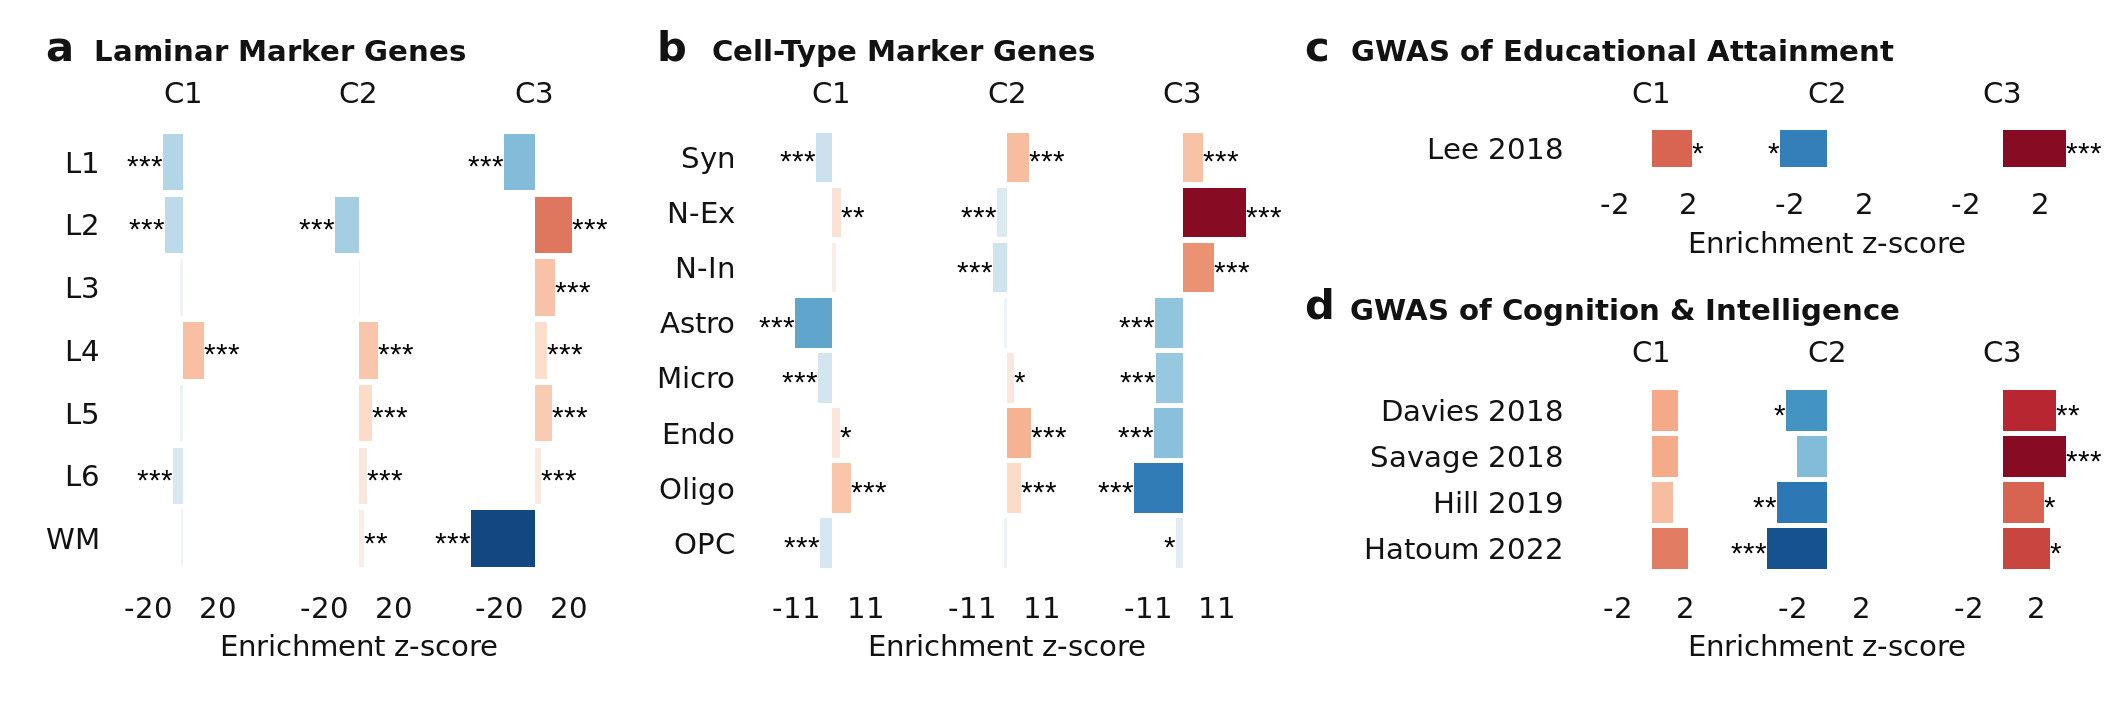

In [40]:
%%R -i cell_stats -i layer_stats -i gwas_intelligence_stats -i gwas_education_stats -w 180 -h 60 --units mm -r 300
source("../code/fig1_plots.R")

g_layers <- plot_enrichment_bars_z(layer_stats) + 
        ggtitle('Laminar Marker Genes') +
        theme(
                axis.text.y = element_text(margin=margin(r=-1, 'mm')),
                plot.title.position = "plot",
                plot.title = element_text(hjust=0.25, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
        )

g_cells <- plot_enrichment_bars_z(cell_stats) + 
        ggtitle('Cell-Type Marker Genes') +
        theme(
                plot.title.position = "plot",
                plot.title = element_text(hjust=0.25, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
        )

g_gwas_intelligence <- plot_enrichment_bars_z(gwas_intelligence_stats) +
        ggtitle('GWAS of Cognition & Intelligence') +
        theme(
                axis.text.y = element_text(margin=margin(t=0,r=0,b=0,l=5,'mm')),
                plot.title = element_text(hjust=0.2, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
                plot.title.position = "plot",
                plot.tag.position = c(0,1)
        )

g_gwas_education <- plot_enrichment_bars_z(gwas_education_stats) +
        ggtitle('GWAS of Educational Attainment') +
        theme(
                axis.text.y = element_text(margin=margin(t=0,r=0,b=0,l=1,'mm')),
                plot.title = element_text(hjust=0.2, vjust=0, margin = margin(t=-1,r=0,b=0,l=0,'mm')),
                plot.title.position = "plot",
                plot.tag.position = c(0,1)
        )

design = c(
    area(t=1, b=20, l=1, r=16),
    area(t=1, b=20, l=17, r=32),
    area(t=1, b=4, l=33, r=48),
    area(t=5, b=20, l=33, r=48)
)

enrichments_panels <- (g_layers + g_cells + g_gwas_education + g_gwas_intelligence) + 
                        plot_layout(design=design) + plot_annotation(tag_level='a')
enrichments_panels

## Combined figure 1

Use `patchwork` package to combine into single figure

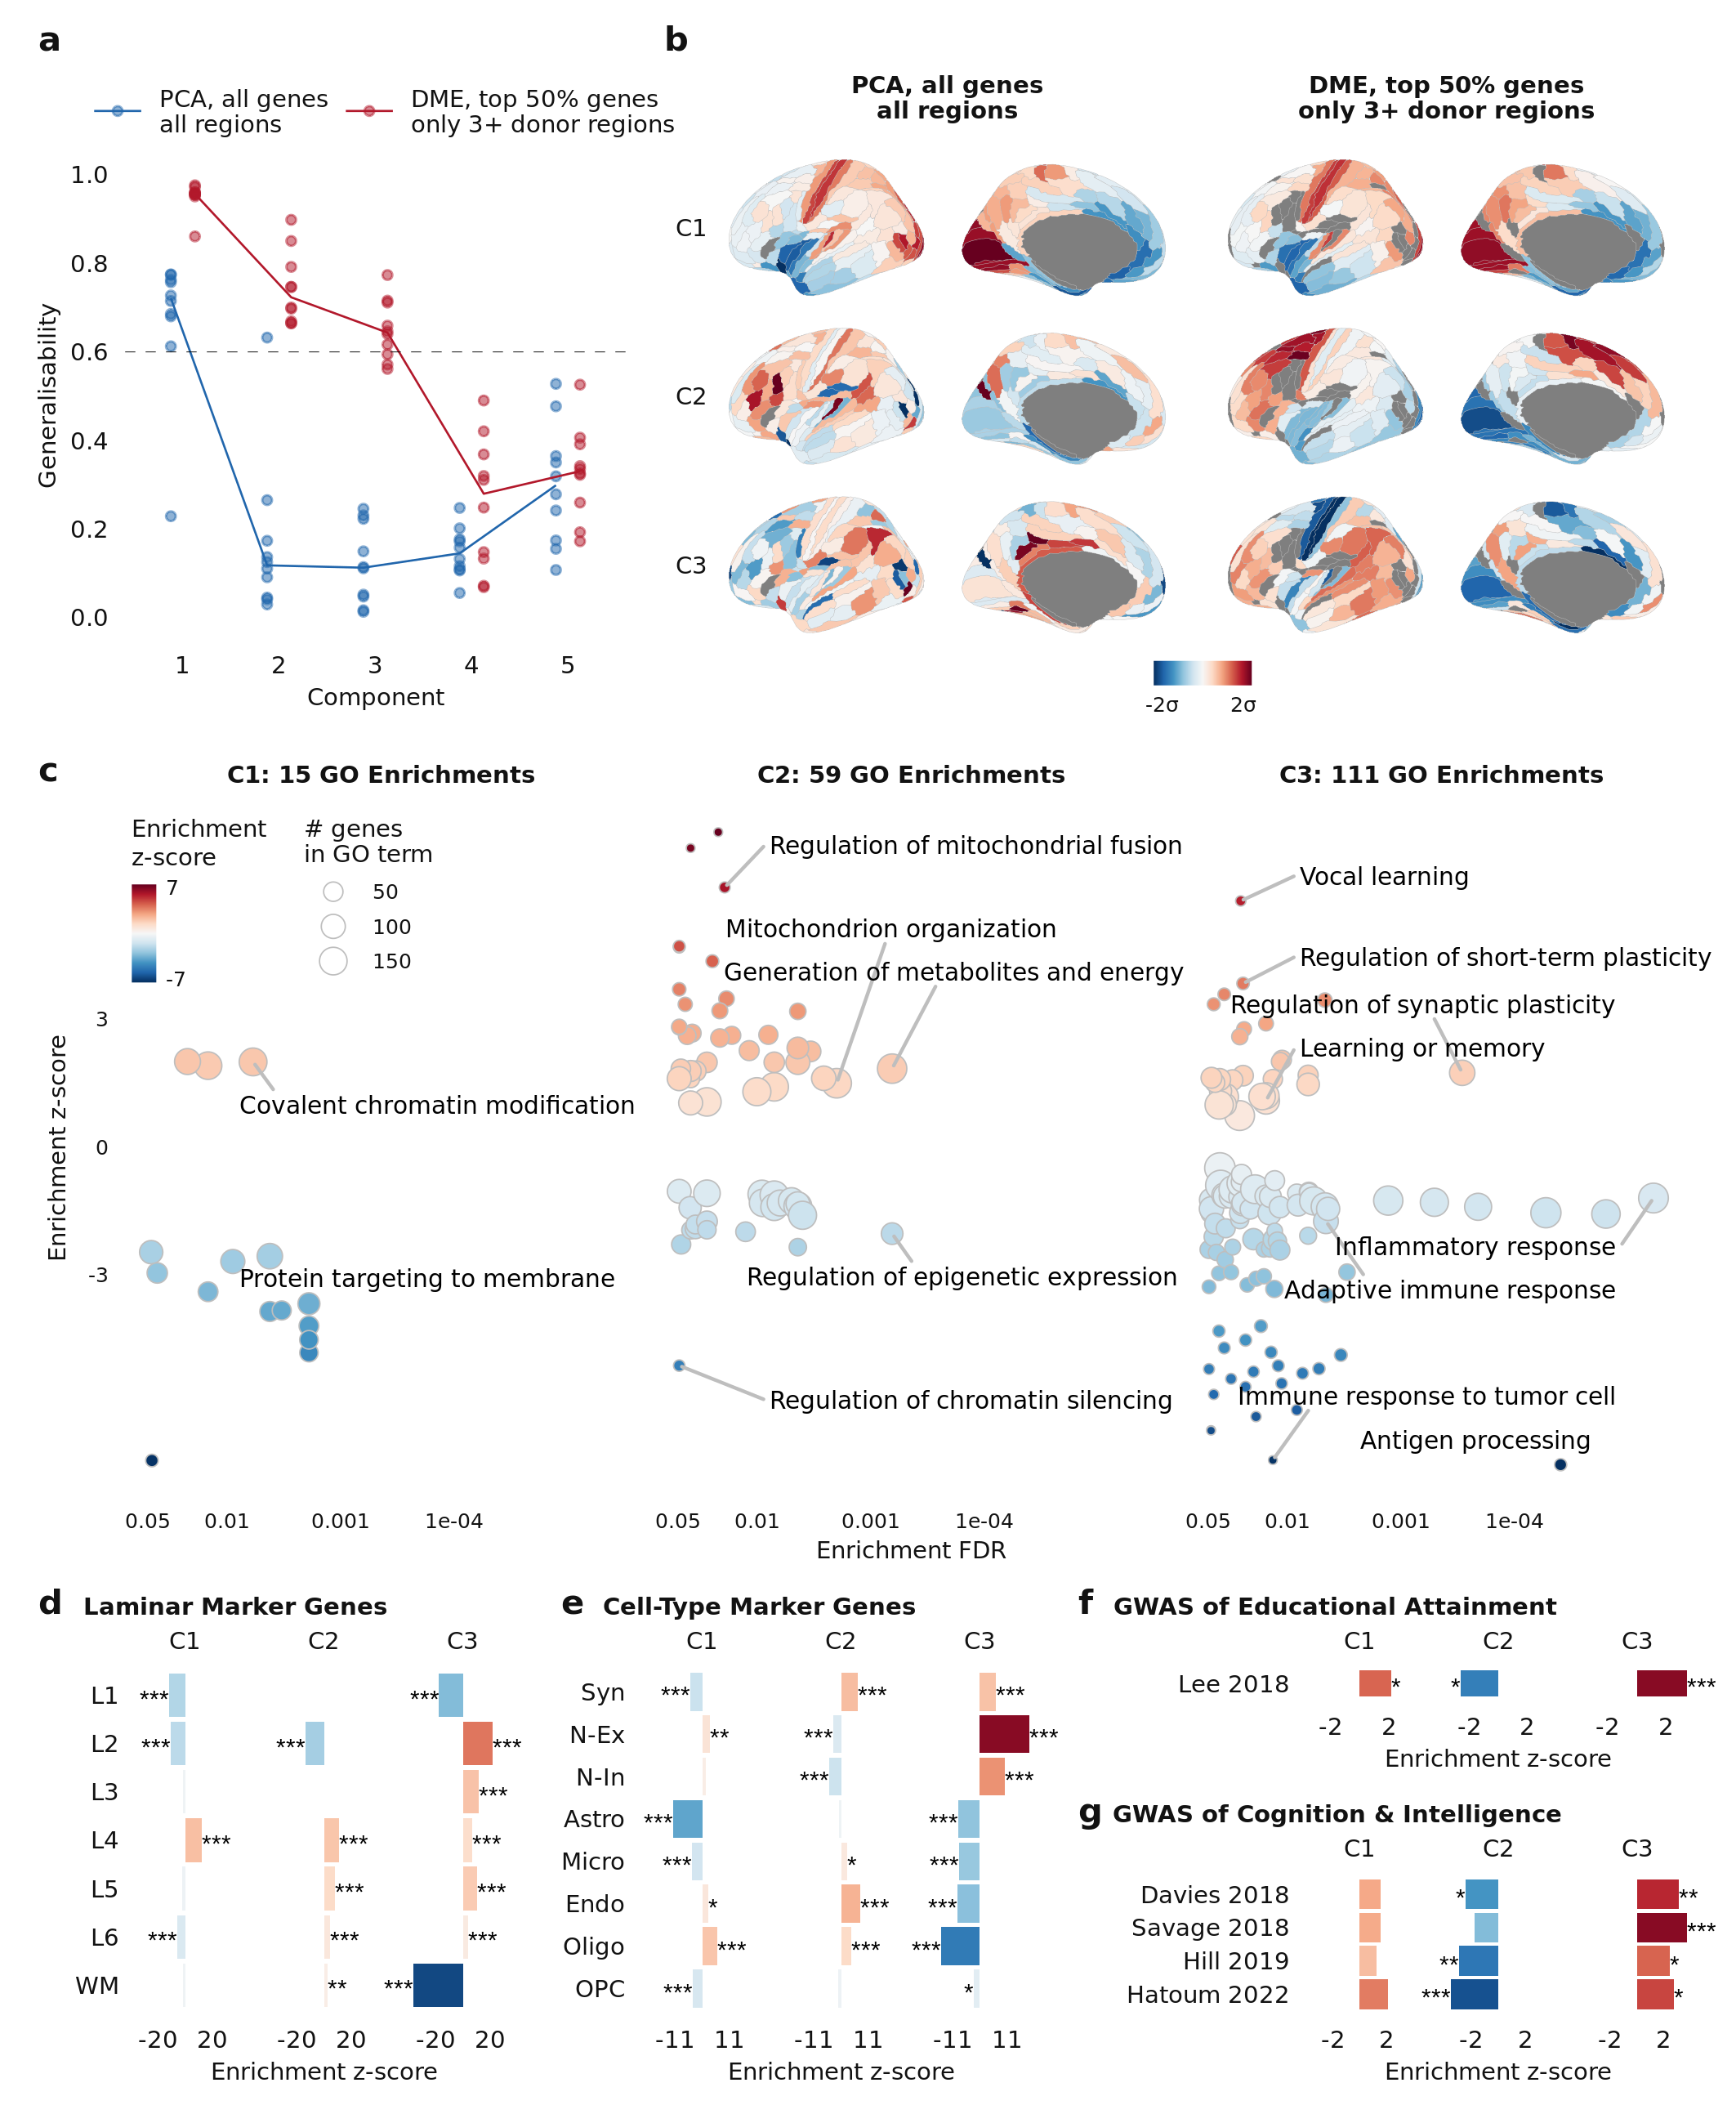

In [52]:
%%R -i triplets_df -i versions_scores -i go_enrichments -w 180 -h 220 --units mm -r 300
source("../code/fig1_plots.R")

p1 <- plot_generalisability(triplets_df) 
p2 <- plot_brain_maps(versions_scores)
p3 <- plot_go_enrichments(go_enrichments) + theme(plot.tag.position = c(0,.975))

layout <- c(
  area(t = 1, b = 70, l = 1, r = 60),
  area(t = 1, b = 70, l = 61, r = 180),
  area(t = 71, b = 170, l = 1, r = 180),
  area(t = 171, b = 220, l = 1, r = 180)
)

plot <- p1 + p2 + p3 + enrichments_panels + plot_layout(design=layout)

themed <- plot & theme(plot.margin = margin(t=2, b=2, l=2, r=2, unit='mm'))

annotated <- themed + plot_annotation(tag_level='a')
annotated

## Other results related to Fig 1

### Burt PC1

In [870]:
burt_pc1 = nib.load("../data/burt_brain_pc1.pscalar.nii").get_fdata()
burt_pc1 = pd.Series(burt_pc1.squeeze(), index=range(1,181), name='Burt_PC1')

In [871]:
scores.join(burt_pc1).corr()

,C1,C2,C3,Burt_PC1
C1,1.000000e+00,5.450628e-07,-6.239683e-07,0.960411
C2,5.450628e-07,1.000000e+00,-6.237271e-07,-0.016629
C3,-6.239683e-07,-6.237271e-07,1.000000e+00,-0.007721
Burt_PC1,9.604106e-01,-1.662941e-02,-7.720735e-03,1.000000


### Cross-correlation

In [162]:
# Scores
dme_3d_ds5.clean_scores().corr()

,C1,C2,C3
C1,1.000000e+00,2.687598e-08,5.443088e-08
C2,2.687598e-08,1.000000e+00,6.623748e-08
C3,5.443088e-08,6.623748e-08,1.000000e+00


In [164]:
# Weights
dme_3d_ds5.weights.corr()

,C1,C2,C3
C1,1.000000,-0.040324,-0.018672
C2,-0.040324,1.000000,-0.106929
C3,-0.018672,-0.106929,1.000000


### Smoothness (Moran's I)

In [165]:
versions_scores.iloc[:,:4].groupby('version', sort=False).agg(get_moran_I).T

version,"PCA, all genes\nall regions","DME, top 50% genes\nonly 3+ donor regions"
C1,0.485524,0.484978
C2,0.090060,0.584921
C3,0.067315,0.205841


### Variance explained

PCA var explained

In [486]:
pca_3d_ds5 = gradientVersion(approach='pca').fit('hcp_3d_ds5')
pca_3d_ds5.eigenvalues / pca_3d_ds5.expression.var().sum()

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3d_ds5


array([0.38643026, 0.10670729, 0.07439592, 0.05532164, 0.03492906])

In [492]:
pca_3d_ds5.corr_scores(dme_3d_ds5)

,0,1,2,3,4
0,0.995508,-0.011770,-0.006964,-0.031811,0.015165
1,0.011112,0.972872,-0.186103,-0.037033,-0.002613
2,0.000571,0.136487,0.878593,-0.196713,0.314559
3,0.015844,0.082656,0.151352,0.906994,0.234354
4,0.016888,-0.011703,0.166416,0.196086,-0.742314


Var explained from regressing out components

In [493]:
get_var_explained(dme_3d_ds5)

array([0.38304296, 0.10311451, 0.06534923])

In [488]:
get_var_explained(pca_3d_ds5)

array([0.38304296, 0.10311451, 0.06534923])

### How many correlated genes

In [166]:
top100 = dme_3d_ds5.weights.abs().rank(ascending=False) < 100
np.nanmean(np.where(top100, dme_3d_ds5.weights.abs(), np.NaN), 0)

array([0.93867909, 0.76972631, 0.6772911 ])

In [171]:
(dme_3d_ds5.weights.abs() > 0.5).sum()

C1    4867
C2     967
C3     437
dtype: int64

In [168]:
(dme_3d_ds5.weights.abs() > 0.5).sum() / len(dme_3d_ds5.weights)

C1    0.610435
C2    0.121284
C3    0.054810
dtype: float64

### XYZ corrs

In [181]:
def get_xyz_corrs(version):
    hcp_xyz = fetch_hcp()['info'].loc[:180,['id','x-cog','y-cog','z-cog']].set_index('id').set_axis(['x','y','z'],axis=1)
    return version.clean_scores().join(hcp_xyz).corr().iloc[3:,:3]

get_xyz_corrs(dme_3d_ds5)

,C1,C2,C3
x,0.031332,-0.075160,0.384444
y,-0.636631,0.496127,-0.028524
z,0.535597,0.580218,-0.159710


In [182]:
get_xyz_corrs(dme_3d_ds5).corr()

,C1,C2,C3
C1,1.000000,0.037724,-0.152041
C2,0.037724,1.000000,-0.993406
C3,-0.152041,-0.993406,1.000000
